In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import json

from modules.interfaces import User, DataBase
from modules.managers import PretradeDataManager, OrderManager, PortfolioManager
from modules.portfolio import *
from modules.tools import *

In [3]:
ac_info = read_json("config/mt5_account.json")["ftmo-demo"]
pre_db_info = read_json("config/postgres_info.json")["pre-trade"]
post_db_info = read_json("config/postgres_info.json")["post-trade"]
params = read_json("config/parameters.json")
asset_allocation = read_json("config/asset_allocation.json")

In [4]:
user = User().login_by_dict(ac_info)
pre_db = DataBase().connect_by_dict(pre_db_info)
post_db = DataBase().connect_by_dict(post_db_info)

Logged in as 1520198341 (FTMO-Demo2)
Connected to pre-trade (localhost:5432)
Connected to post-trade (localhost:5432)


In [5]:
pdm = PretradeDataManager(user, pre_db)
om = OrderManager(user, post_db)
pm = PortfolioManager(om, pdm, asset_allocation, params)

In [6]:
df = pdm.get_universe()

In [7]:
temp = df.loc[df.asset_class=='forex'].sort_values('spread')

In [8]:
all_bars = {symbol: pdm.get_bars(symbol).drop(columns='real_volume') for symbol in temp.symbol}

In [9]:
for s,b in all_bars.items():
  vol = np.log(b.close).diff().ewm(48).std()
  vol = 0.7*vol + 0.3*vol.rolling(6000).mean()
  vol = b.close * vol
  b['open'] = (b.open.diff() / vol).cumsum()
  b['high'] = (b.high.diff() / vol).cumsum()
  b['low'] = (b.low.diff() / vol).cumsum()
  b['close'] = (b.close.diff() / vol).cumsum()
  
  v_vol = np.log(b.tick_volume).diff().ewm(48).std()
  v_vol = 0.7*v_vol + 0.3*v_vol.rolling(6000).mean()
  v_vol = b.tick_volume * v_vol
  b['tick_volume'] = (b.tick_volume.diff() / v_vol).cumsum()
  b.dropna(inplace=True)
  all_bars[s] = b

In [10]:
idxs = list()
s_del = list()
for s,b in  all_bars.items():
  b = b.dropna()
  if len(b.index)<=36000:
    s_del.append(s)
    continue
  idxs.append(b.index)

In [11]:
d = all_bars.copy()
for s in s_del:
  del d[s]

In [12]:
len(d)

39

In [17]:
all_bars = d

In [18]:
final_idx = idxs[0]
for idx in idxs:
  final_idx = final_idx.intersection(idx)

In [19]:
final_idx

DatetimeIndex(['2015-12-23 16:00:00', '2015-12-23 17:00:00',
               '2015-12-23 18:00:00', '2015-12-23 19:00:00',
               '2015-12-23 20:00:00', '2015-12-23 21:00:00',
               '2015-12-23 22:00:00', '2015-12-23 23:00:00',
               '2015-12-24 00:00:00', '2015-12-24 01:00:00',
               ...
               '2024-05-23 02:00:00', '2024-05-23 03:00:00',
               '2024-05-23 04:00:00', '2024-05-23 05:00:00',
               '2024-05-23 06:00:00', '2024-05-23 07:00:00',
               '2024-05-23 08:00:00', '2024-05-23 09:00:00',
               '2024-05-23 10:00:00', '2024-05-23 11:00:00'],
              dtype='datetime64[ns]', name='time', length=48104, freq=None)

In [20]:
train_idx = final_idx[:len(final_idx)//3]
val_idx = final_idx[len(final_idx)//3:len(final_idx)//3*2]
test_idx = final_idx[len(final_idx)//3*2:]

In [21]:
train_set = {symbol: all_bars[symbol].loc[train_idx] for symbol in all_bars.keys()}
val_set = {symbol: all_bars[symbol].loc[val_idx] for symbol in all_bars.keys()}
test_set = {symbol: all_bars[symbol].loc[test_idx] for symbol in all_bars.keys()}

In [30]:
data = pd.DataFrame({symbol:train_set[symbol].close for symbol in train_set.keys()})

In [175]:
from sklearn.cluster import KMeans

# Calculate the correlation matrix
corr_matrix = data.diff().corr()

# Perform K-Means clustering on the correlation matrix
num_clusters = 8  # Set the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(corr_matrix)

# Get the cluster labels for each asset
asset_labels = kmeans.labels_

# Create a dictionary to store the asset names grouped by cluster
asset_clusters = {f"Cluster {i+1}": [] for i in range(num_clusters)}

# Populate the dictionary with the asset names
for i, asset in enumerate(corr_matrix.columns):
    cluster = asset_labels[i]
    asset_clusters[f"Cluster {cluster+1}"].append(asset)

# Print the resulting asset clusters
for cluster, assets in asset_clusters.items():
    print(f"{cluster}: {', '.join(assets)}")

c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 1: USDCAD, USDCHF, USDCZK, USDPLN, USDHUF, USDSEK, USDNOK
Cluster 2: AUDNZD, EURGBP, EURNZD, USDHKD
Cluster 3: AUDUSD, AUDCHF, AUDJPY, CADCHF, CADJPY
Cluster 4: EURUSD, GBPUSD, EURCHF, GBPCHF, EURJPY, GBPJPY
Cluster 5: EURAUD, GBPNZD, GBPAUD, GBPCAD
Cluster 6: NZDUSD, AUDCAD, NZDCHF, NZDJPY
Cluster 7: NZDCAD, EURCAD, EURCZK, EURPLN, EURNOK, USDMXN, USDZAR
Cluster 8: USDJPY, CHFJPY


In [275]:
pos = pd.DataFrame()
for cluster, assets in asset_clusters.items():
  index = pd.concat([all_bars[asset].close for asset in assets],axis=1).mean(axis=1)
  for asset in assets:
    signal = (index-index.ewm(120).mean())/index.ewm(120).std()
    
    long_signal = np.where(signal >= 2,-1,0)
    short_signal = np.where(signal < -2,1,0)
    
    pos[asset] = -pd.Series(long_signal+short_signal,index=signal.index)
    pos[asset].loc[pos[asset]==0]=np.nan

C:\Users\benka\AppData\Local\Temp\ipykernel_13188\1523879450.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos[asset].loc[pos[asset]==0]=np.nan
C:\Users\benka\AppData\Local\Temp\ipykernel_13188\1523879450.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos[asset].loc[pos[asset]==0]=np.nan
C:\Users\benka\AppData\Local\Temp\ipykernel_13188\1523879450.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos[asset].loc[pos[asse

In [276]:
all_pnl = pos * all_ret

<Axes: xlabel='time'>

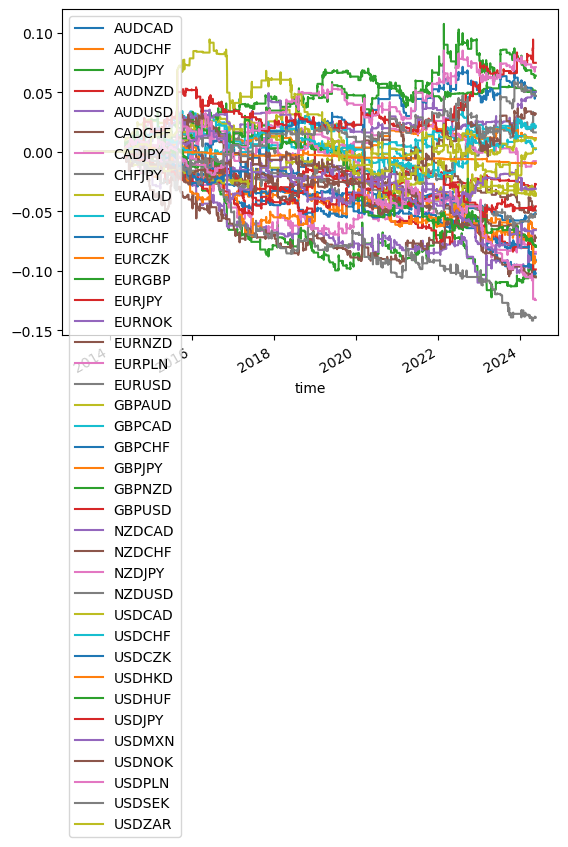

In [277]:
all_pnl.fillna(0).cumsum().plot()

In [278]:
all_cost = pos.diff().abs() * all_spread/2

In [279]:
np.around(pd.DataFrame({'pnl':all_pnl.mean()*6000,'cost':all_cost.mean()*6000,'net_pnl':all_pnl.mean()*6000-all_cost.mean()*6000}).sort_values('pnl',ascending=False)*100,2)

,pnl,cost,net_pnl
USDHUF,31.38,7.71,23.67
USDPLN,31.17,6.74,24.43
EURNOK,27.36,37.68,-10.32
USDJPY,26.61,0.00,26.61
USDCZK,22.94,8.12,14.82
EURGBP,21.03,0.00,21.03
USDSEK,20.80,0.11,20.69
USDNOK,13.73,0.73,12.99
EURCAD,11.03,0.51,10.52
USDCHF,8.97,0.00,8.97


<Axes: xlabel='time'>

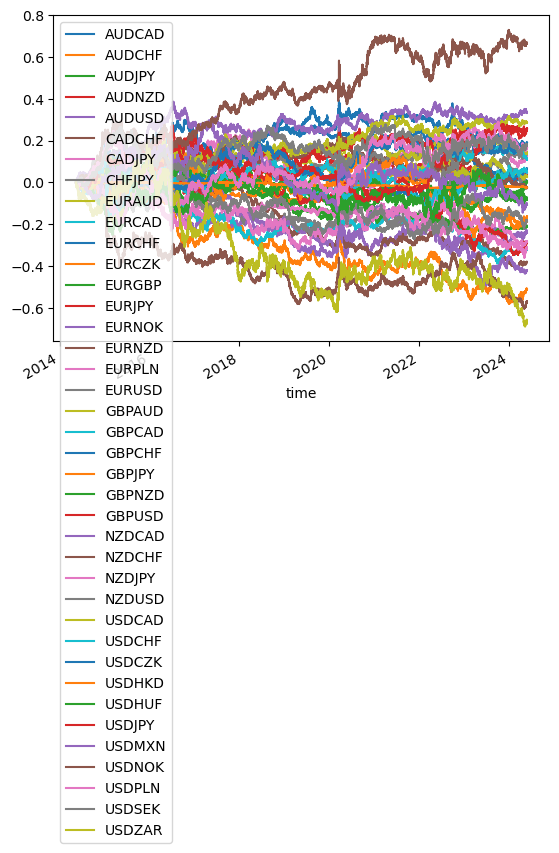

In [188]:
all_pnl.cumsum().plot()

In [ ]:
all_ret = pd.DataFrame({symbol: np.log(pdm.get_bars(symbol).close).diff().shift(-1) for symbol in all_bars.keys()})

In [95]:
all_spread = pd.DataFrame({symbol: pdm.get_bars(symbol).spread / pdm.get_bars(symbol).close for symbol in all_bars.keys()})

In [96]:
points = temp.set_index('symbol').point

all_spread = all_spread.mul(points,axis=1)

In [56]:
fast_ema = cluster_returns.cumsum().ewm(1).mean().dropna()
slow_ema = cluster_returns.cumsum().ewm(48).mean().dropna()
pos = pd.DataFrame(np.ones(slow_ema.shape),index=slow_ema.index,columns=slow_ema.columns)
pos[fast_ema>slow_ema] = -1

<Axes: xlabel='time'>

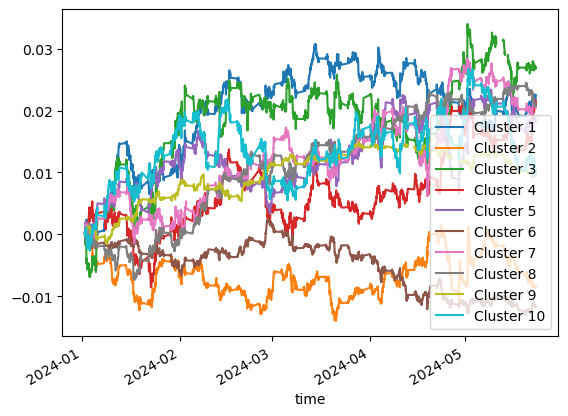

In [59]:
(pos*cluster_returns.shift(-1)).loc['2024':].cumsum().plot()

<Axes: xlabel='time'>

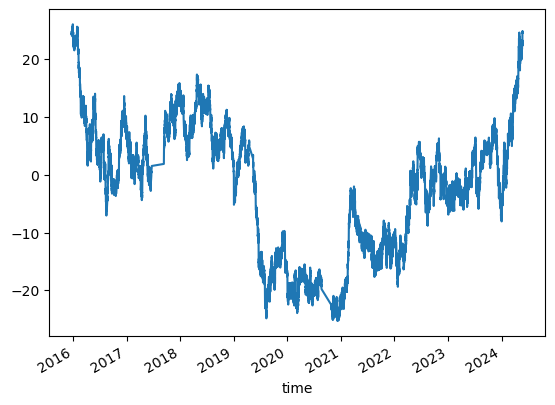

In [36]:
simple = pd.DataFrame({symbol:all_bars[symbol].close for symbol in all_bars.keys()})
simple.dropna().mean(axis=1).plot()

In [21]:
d = dict()
for i, r in temp.iterrows():
    # print(r)
    rate_name = r.currency_profit + "USD"

    if rate_name == "USDUSD":
        d[r.symbol] = rate_name
    elif rate_name in temp.symbol.to_list():
        ans = input("y:" + rate_name)
        if ans != "":
            rate_name = ans
        d[r.symbol] = rate_name
    else:
        rate_name = rate_name[3:] + rate_name[:3]
        ans = input("n:" + rate_name)
        if ans != "":
            rate_name = ans
        d[r.symbol] = rate_name

In [22]:
print(d)

{'EURUSD': 'USDUSD', 'AUDUSD': 'USDUSD', 'AUDNZD': 'NZDUSD', 'NZDUSD': 'USDUSD', 'EURGBP': 'GBPUSD', 'GBPUSD': 'USDUSD', 'USDCAD': 'USDCAD', 'USDCHF': 'USDCHF', 'EURCHF': 'USDCHF', 'AUDCHF': 'USDCHF', 'AUDCAD': 'USDCAD', 'EURAUD': 'AUDUSD', 'AUDJPY': 'USDJPY', 'USDJPY': 'USDJPY', 'NZDCAD': 'USDCAD', 'NZDCHF': 'USDCHF', 'NZDJPY': 'USDJPY', 'EURNZD': 'NZDUSD', 'GBPNZD': 'NZDUSD', 'CADCHF': 'USDCHF', 'GBPCHF': 'USDCHF', 'EURCAD': 'USDCAD', 'EURJPY': 'USDJPY', 'USDILS': 'USDILS', 'GBPAUD': 'AUDUSD', 'CADJPY': 'USDJPY', 'GBPCAD': 'USDCAD', 'GBPJPY': 'USDJPY', 'CHFJPY': 'USDJPY', 'USDHKD': 'USDHKD', 'EURCZK': 'USDCZK', 'USDCZK': 'USDCZK', 'EURPLN': 'USDPLN', 'USDPLN': 'USDPLN', 'USDHUF': 'USDHUF', 'USDSEK': 'USDSEK', 'EURNOK': 'USDNOK', 'USDNOK': 'USDNOK', 'USDMXN': 'USDMXN', 'USDZAR': 'USDZAR'}


In [24]:
print(list(d.keys()))

['EURUSD', 'AUDUSD', 'AUDNZD', 'NZDUSD', 'EURGBP', 'GBPUSD', 'USDCAD', 'USDCHF', 'EURCHF', 'AUDCHF', 'AUDCAD', 'EURAUD', 'AUDJPY', 'USDJPY', 'NZDCAD', 'NZDCHF', 'NZDJPY', 'EURNZD', 'GBPNZD', 'CADCHF', 'GBPCHF', 'EURCAD', 'EURJPY', 'USDILS', 'GBPAUD', 'CADJPY', 'GBPCAD', 'GBPJPY', 'CHFJPY', 'USDHKD', 'EURCZK', 'USDCZK', 'EURPLN', 'USDPLN', 'USDHUF', 'USDSEK', 'EURNOK', 'USDNOK', 'USDMXN', 'USDZAR']


In [26]:
for k in d.keys():
  print(f'from .{k.lower()} import {k}')

from .eurusd import EURUSD
from .audusd import AUDUSD
from .audnzd import AUDNZD
from .nzdusd import NZDUSD
from .eurgbp import EURGBP
from .gbpusd import GBPUSD
from .usdcad import USDCAD
from .usdchf import USDCHF
from .eurchf import EURCHF
from .audchf import AUDCHF
from .audcad import AUDCAD
from .euraud import EURAUD
from .audjpy import AUDJPY
from .usdjpy import USDJPY
from .nzdcad import NZDCAD
from .nzdchf import NZDCHF
from .nzdjpy import NZDJPY
from .eurnzd import EURNZD
from .gbpnzd import GBPNZD
from .cadchf import CADCHF
from .gbpchf import GBPCHF
from .eurcad import EURCAD
from .eurjpy import EURJPY
from .usdils import USDILS
from .gbpaud import GBPAUD
from .cadjpy import CADJPY
from .gbpcad import GBPCAD
from .gbpjpy import GBPJPY
from .chfjpy import CHFJPY
from .usdhkd import USDHKD
from .eurczk import EURCZK
from .usdczk import USDCZK
from .eurpln import EURPLN
from .usdpln import USDPLN
from .usdhuf import USDHUF
from .usdsek import USDSEK
from .eurnok import EURNOK
f

In [24]:
symbol1 = 'AUDUSD'
symbol2 = 'NZDUSD'

concat_close = pd.DataFrame({'0':pdm.get_bars(symbol1).close,
                             '1':pdm.get_bars(symbol2).close}).dropna()

In [25]:
uni = pdm.get_universe()
point = uni.set_index("symbol").point
concat_cost = pd.DataFrame(
    {
        "0": pdm.get_bars(symbol1).spread
        * point[symbol1]
        / pdm.get_bars(symbol1).close,
        "1": pdm.get_bars(symbol2).spread
        * point[symbol2]
        / pdm.get_bars(symbol1).close,
    }
).dropna()

In [107]:
start, end = 0, len(concat_close) - 1
idx = concat_close.index

train_size = 6000  # ~1 year
step_size = 120

r2_l = list()
signal_l = list()
comb_pos_l = list()

from sklearn.linear_model import RidgeCV

while True:
    # start ----- (train_size-1) days -----> end
    start_train = idx[start]
    end_train = idx[start + train_size - 1]

    # end+1 ----- (step-1) days -----------> end test
    start_test = idx[start + train_size - train_size]
    end_test = idx[min(start + train_size + step_size - 1, end)]

    org_train_set = concat_close.loc[:end_train]
    train_set = org_train_set.apply(lambda s: get_ewsamples(s, period=train_size))
    test_set = concat_close.loc[start_test:end_test]

    org_train_y, org_train_x = org_train_set["0"], org_train_set[["1"]]
    train_y, train_x = train_set["0"], train_set[["1"]]
    test_y, test_x = test_set["0"], test_set[["1"]]

    # print(f"Train ---- {start_train} : {end_train}")
    model = RidgeCV(cv=5, fit_intercept=False)
    model.fit(train_x, train_y)
    # print(f"    R2 = {model.score(train_x,train_y)}")

    # print(f"Test  ---- {start_test} : {end_test}")
    # print(f"    R2 = {model.score(test_x,test_y)}")
    # print(model.intercept_, model.coef_)

    r2 = model.score(train_x, train_y)
    r2_l.append(r2)
    if True:
        # mean_abs_err = (
        #    (train_y - pd.Series(model.predict(train_x), index=train_x.index))
        #    .abs()
        #    .mean()
        # )
        # var_y = train_y.std() ** 2
        # var_u = (1 - r2) * var_y
        # std_u = var_u**0.5

        h = model.coef_[0]
        pair_value = test_y - h * test_x["1"]
        exp_value = model.intercept_
        # exp_value = pair_value.ewm(train_size, min_periods=train_size + 1).mean()
        # std_u = pair_value.ewm(train_size, min_periods=train_size + 1).std()

        # signal = ((pair_value - exp_value) / std_u).dropna()
        signal = (pair_value - exp_value).dropna()
        signal = signal / signal.abs().expanding().mean()
        signal_l.append(signal)

        # long_pos = pd.Series(np.where(signal <= -2, 1, 0), signal.index)
        # short_pos = pd.Series(np.where(signal >= 2, -1, 0), signal.index)
        # pos = long_pos + short_pos
        pos = -signal.clip(upper=2, lower=-2)

        comb_pos = pd.DataFrame({"0": 1 * pos, "1": -h * pos})
        comb_pos_l.append(comb_pos)
    else:
        signal_l.append(pd.Series(0, index=test_y.index))
        comb_pos_l.append(pd.DataFrame({"0": 0, "1": 0}, index=test_y.index))
        
    start += step_size
    if start + train_size >= end:
        break


In [108]:
pos = np.around(pd.concat(comb_pos_l) * 5) / 5
ew_pnl = (pos * np.log(concat_close).diff().shift(-1)).sum(axis=1)
costs = (pos.diff().abs() * concat_cost).sum(axis=1)

In [109]:
def sr(pnl):
  pnl = pnl.resample('d').sum()
  m = pnl.mean()*252
  s = pnl.std()*np.sqrt(252)
  sr = m/s
  return sr
def pf(pnl):
  pnl = pnl.resample('d').sum()
  g = pnl.clip(lower=0).sum()
  l = -pnl.clip(upper=0).sum()
  pf = g/l
  return pf

<Axes: xlabel='time'>

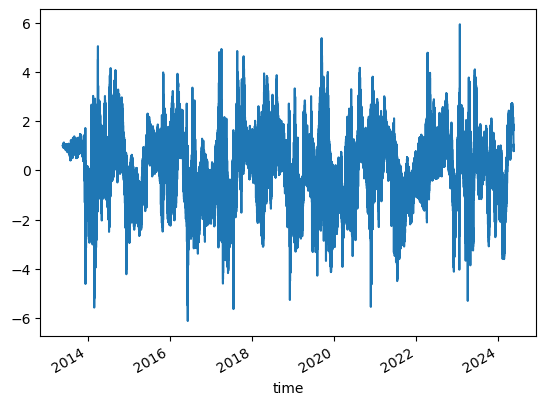

In [110]:
pd.concat(signal_l).plot()

In [111]:
print(sr(ew_pnl),pf(ew_pnl))
#print(sr(pnl),pf(pnl))

1.4751659475327756 1.4391185547701981


In [112]:
lev_factor = 0.2 / (ew_pnl.std() * np.sqrt(24 * 252))

<Axes: xlabel='time'>

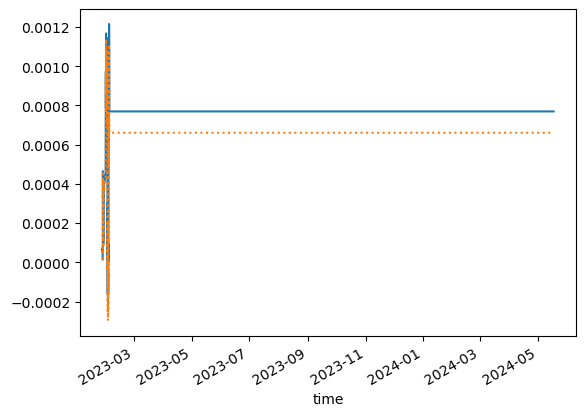

In [106]:
(ew_pnl / lev_factor).loc[start_test:].cumsum().plot()
((ew_pnl - costs) / lev_factor).loc[start_test:].cumsum().plot(linestyle=":")